In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification,TrainingArguments, Trainer,DistilBertTokenizerFast,DataCollatorWithPadding
from transformers import BertForSequenceClassification
from sklearn.preprocessing import label_binarize
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc,confusion_matrix




In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA L4


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
model.to("cuda")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [4]:
print(next(model.parameters()).device)

cuda:0


In [5]:
train_df = pd.read_csv("train.csv")
print(train_df.shape)
train_df.head()

(5616, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,lrs consulting services has been delivering th...,<<summarysenior lead release engineer speciali...,[ 101 1048 2869 10552 2578 2038 2042 127...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,2,"driven, empowering, transformative. academic p...",<<summaryleadership-oriented certified technol...,[ 101 5533 1010 7861 23948 1010 10938 80...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,1,position title: senior accountant organization...,<<profilededicated epidemiologist/data manager...,[ 101 2597 2516 1024 3026 17907 3029 10...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,1,"at farmer brothers, sales tax accountant will ...",<<summaryseasoned data architect adept at unde...,[ 101 2012 7500 3428 1010 4341 4171 179...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,0,job description i am actively seeking an exper...,<<summaryenergetic and personableadministrativ...,[ 101 3105 6412 1045 2572 8851 6224 20...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [6]:
test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df.head()

(1759, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,key responsibilities:create intricate wiring n...,<<summary7+ years of experience as a bi develo...,[ 101 3145 10198 1024 3443 17796 27930 61...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,1,personal development and becoming the best you...,<<professional backgroundanalyst versed in dat...,[ 101 3167 2458 1998 3352 1996 2190 20...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,1,"location: tampa, fl exp: 7-10 yrs spoc: tushar...",<<executive profilededicated professional with...,[ 101 3295 1024 9925 1010 13109 4654 23...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,1,"primary location: melbourne, florida v-soft co...","<<summarytyee highlightsmicrosoft excel, word,...",[ 101 3078 3295 1024 4940 1010 3516 10...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,1,at oregon specialty group the accounting & pay...,<<summaryeit certified engineer and astqb cert...,[ 101 2012 5392 12233 2177 1996 9529 10...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [7]:
val_df = pd.read_csv("validation.csv")
print(val_df.shape)
val_df.head()

(625, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,0,job description job title: salesforce communic...,<<summaryi am a computer engineer with over 12...,[ 101 3105 6412 3105 2516 1024 4341 148...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,1,"at farmer brothers, sales tax accountant will ...",<<profilehighly motivated sales associate with...,[ 101 2012 7500 3428 1010 4341 4171 179...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,0,"hello,greetings from devcare solutionsi got an...",<<professional summaryhighly motivated sales a...,[ 101 7592 1010 14806 2015 2013 16475 163...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,1,if you can handle the accounting responsibilit...,<<summarymy name is jessica claire and i am in...,[ 101 2065 2017 2064 5047 1996 9529 101...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,0,job purpose: perform designated tasks in the a...,<<summarycapable accountant successful at mana...,[ 101 3105 3800 1024 4685 4351 8518 19...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [ ]:
import re

def clean_and_convert(x):
    # already clean
    if isinstance(x, list):
        return x  
    
    # 1. Remove brackets if present
    x = x.replace("[", "").replace("]", "")
    
    # 2. Strip spaces
    x = x.strip()
    
    # 3. Split by ANY whitespaces (handles double/triple spaces)
    parts = re.split(r"\s+", x)
    
    # 4. Convert each token to integer
    return [int(p) for p in parts if p.isdigit()]


In [9]:
for df in [train_df, val_df, test_df]:
    df["input_ids"] = df["input_ids"].apply(clean_and_convert)
    df["attention_mask"] = df["attention_mask"].apply(clean_and_convert)


In [10]:
train_df.head()

,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,lrs consulting services has been delivering th...,<<summarysenior lead release engineer speciali...,"[101, 1048, 2869, 10552, 2578, 2038, 2042, 127...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,"driven, empowering, transformative. academic p...",<<summaryleadership-oriented certified technol...,"[101, 5533, 1010, 7861, 23948, 1010, 10938, 80...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1,position title: senior accountant organization...,<<profilededicated epidemiologist/data manager...,"[101, 2597, 2516, 1024, 3026, 17907, 3029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"at farmer brothers, sales tax accountant will ...",<<summaryseasoned data architect adept at unde...,"[101, 2012, 7500, 3428, 1010, 4341, 4171, 1790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,job description i am actively seeking an exper...,<<summaryenergetic and personableadministrativ...,"[101, 3105, 6412, 1045, 2572, 8851, 6224, 2019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:


train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)
test_ds  = Dataset.from_pandas(test_df)


In [12]:
cols = ["input_ids", "attention_mask", "labels"]

train_ds = train_ds.with_format("torch", columns=cols)
val_ds   = val_ds.with_format("torch", columns=cols)
test_ds  = test_ds.with_format("torch", columns=cols)


##### Creating the full df by concating train,val, test

In [12]:
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(full_df.shape)
full_df.head()

(8000, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,lrs consulting services has been delivering th...,<<summarysenior lead release engineer speciali...,"[101, 1048, 2869, 10552, 2578, 2038, 2042, 127...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,"driven, empowering, transformative. academic p...",<<summaryleadership-oriented certified technol...,"[101, 5533, 1010, 7861, 23948, 1010, 10938, 80...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1,position title: senior accountant organization...,<<profilededicated epidemiologist/data manager...,"[101, 2597, 2516, 1024, 3026, 17907, 3029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"at farmer brothers, sales tax accountant will ...",<<summaryseasoned data architect adept at unde...,"[101, 2012, 7500, 3428, 1010, 4341, 4171, 1790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,job description i am actively seeking an exper...,<<summaryenergetic and personableadministrativ...,"[101, 3105, 6412, 1045, 2572, 8851, 6224, 2019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
train_df, temp_df = train_test_split(
    full_df,
    test_size=0.30,
    stratify=full_df["labels"],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["labels"],
    random_state=42
)
print(train_df.shape, val_df.shape, test_df.shape)

(5600, 5) (1200, 5) (1200, 5)


In [ ]:
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))


In [17]:
test_ds

Dataset({
    features: ['labels', 'jd_cleaned', 'resume_cleaned', 'input_ids', 'attention_mask'],
    num_rows: 1200
})

In [18]:
cols = ["input_ids", "attention_mask", "labels"]

train_ds = train_ds.remove_columns([c for c in train_ds.column_names if c not in cols])
val_ds   = val_ds.remove_columns([c for c in val_ds.column_names if c not in cols])
test_ds  = test_ds.remove_columns([c for c in test_ds.column_names if c not in cols])


In [19]:
train_ds

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 5600
})

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


In [ ]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
num_labels = len(train_df["labels"].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)
model.gradient_checkpointing_enable() 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_df["labels"]),
    y=train_df["labels"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda")


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = F.softmax(torch.tensor(logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)

    try:
        auc = roc_auc_score(labels, probs, multi_class="ovr")
    except:
        auc = float("nan")

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "auc": auc,
    }


In [ ]:
args = TrainingArguments(
    output_dir="bert-base-advanced",

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",

    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",

    num_train_epochs=8,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,

    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    label_smoothing_factor=0.05,

    fp16=True,
    report_to="none",
)


In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


/scratch/local/20558795/ipykernel_723032/835306993.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [33]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auc
1,1.094800,1.046173,0.470000,0.465317,0.681994
2,0.911000,0.778455,0.605833,0.599582,0.822773
3,0.718000,0.735232,0.638333,0.641560,0.853476
4,0.626700,0.665936,0.710833,0.710713,0.873267
5,0.522100,0.664735,0.725833,0.724761,0.882785
6,0.417500,0.748494,0.725000,0.725152,0.886540
7,0.336800,0.807165,0.740833,0.740451,0.891603
8,0.286300,0.821836,0.742500,0.741393,0.892288


TrainOutput(global_step=5600, training_loss=0.6141505704607282, metrics={'train_runtime': 775.4473, 'train_samples_per_second': 57.773, 'train_steps_per_second': 7.222, 'total_flos': 1.17874811142144e+16, 'train_loss': 0.6141505704607282, 'epoch': 8.0})

In [36]:
trainer.evaluate(val_ds)

{'eval_loss': 0.8218357563018799,
 'eval_accuracy': 0.7425,
 'eval_f1': 0.7413929617435224,
 'eval_auc': 0.8922876543209877,
 'eval_runtime': 4.1657,
 'eval_samples_per_second': 288.07,
 'eval_steps_per_second': 36.009,
 'epoch': 8.0}

In [35]:
trainer.evaluate(test_ds)

{'eval_loss': 0.811338484287262,
 'eval_accuracy': 0.735,
 'eval_f1': 0.7348355899024331,
 'eval_auc': 0.8857709876543209,
 'eval_runtime': 4.16,
 'eval_samples_per_second': 288.464,
 'eval_steps_per_second': 36.058,
 'epoch': 8.0}

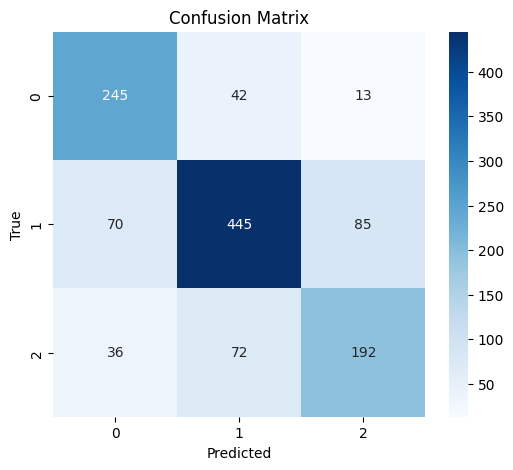

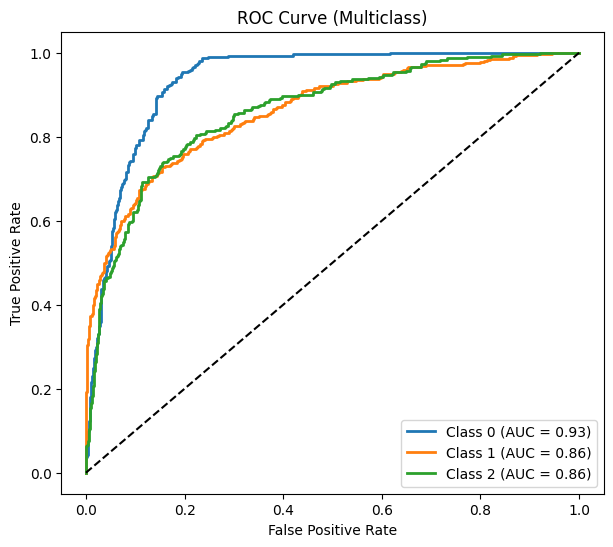

Macro AUC: 0.8857709876543209


In [ ]:
# --- Get predictions ---
predictions = trainer.predict(test_ds)
logits = predictions.predictions
labels = predictions.label_ids

# --- Convert to probabilities + preds ---
probs = F.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- ROC Curve ---
num_classes = probs.shape[1]
labels_onehot = label_binarize(labels, classes=list(range(num_classes)))

plt.figure(figsize=(7, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_onehot[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.show()

# --- Final AUC score ---
auc_macro = roc_auc_score(labels_onehot, probs, multi_class="ovr", average="macro")
print("Macro AUC:", auc_macro)
